<a href="https://colab.research.google.com/github/Sergrey5571/Sergrey5571/blob/main/GAN_Light.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание и загрузка библиотек



Запустите базовую генеративную сеть, с Dense генератором и дискриминатором

Поменяйте размер внутреннего пространства генератора с 100 на 10 и 1000, сравните результаты.

Сделайте свёрточный генератор, сравните результаты с полносвязным генератором

Сделайте возможность запускать обучение с разными batch_size для генератора и дискриминатора, попробуйте запустить с batch_size 128 для дискриминатора и 256 для генератора, сравните результат с равными batch_size по 128.

In [ ]:
from keras.datasets import mnist,cifar10
from keras.layers import Dense, Input, Reshape, Flatten, Dropout, BatchNormalization, Activation, MaxPool2D, Embedding, concatenate, multiply
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt

# Генератор и Дискриминатор

In [ ]:
img_rows = 28 #высота
img_cols = 28 #ширина 
channels = 1 #глубина
img_shape = (img_rows, img_cols, channels)
latent_dim = 100
batch_size = 128

optimizer = Adam(0.0002, 0.5)

In [ ]:
!mkdir images # создание каталога images

функция генератора:

In [ ]:
def create_generator():
  generator = Sequential()
  generator.add(Dense(256, input_dim = latent_dim))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization(momentum=0.8))
  generator.add(Dense(512))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization(momentum=0.8))
  generator.add(Dense(1024))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization(momentum=0.8))
  generator.add(Dense(np.prod(img_shape), activation='tanh'))
  generator.add(Reshape(img_shape))

  noise = Input(shape=(latent_dim, )) # данные входа с размерностью latent_dim
  img = generator(noise) #  созданное генератором из noise

  generator = Model(noise, img) # модель вход-выход

  return generator

In [ ]:
gen = create_generator()
gen.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_5 (Sequential)   (None, 28, 28, 1)         1493520   
                                                                 
Total params: 1,493,520
Trainable params: 1,489,936
Non-trainable params: 3,584
_________________________________________________________________


In [ ]:
input1 = np.random.random(size=(1, 100))
plt.imshow(input1, cmap='gray')
plt.axis('off')
predict_gen = gen.predict(input1)
plt.show()

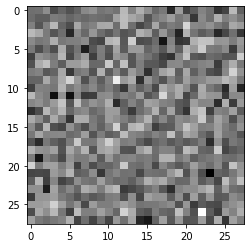

In [ ]:
plt.imshow(predict_gen[0].reshape(28, 28), cmap='gray')
plt.show()

дискриминатор:

In [ ]:
def create_discriminator():
  discriminator = Sequential()
  discriminator.add(Flatten(input_shape = img_shape)) # разворачиваем картинку 28х28
  discriminator.add(Dense(512))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dense(256))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dense(1, activation='sigmoid'))

  img = Input(shape=img_shape) # входной слой (28,28,1)
  validity = discriminator(img) #дискриминатор от img
  discriminator = Model(img, validity) # моделка с вход-выход

  discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  discriminator.trainable = False # заморозка обучения
  return discriminator

In [ ]:
dis = create_discriminator()
dis.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 sequential_4 (Sequential)   (None, 1)                 533505    
                                                                 
Total params: 533,505
Trainable params: 0
Non-trainable params: 533,505
_________________________________________________________________


In [ ]:
predict_dis = dis.predict(predict_gen) # получается предикт от предикта рамдомного значения шума
print(predict_dis)

[[0.53948146]]


In [ ]:
batch_size = 128 # сразу как в задании. Только зачем два раза указывать? Указали же выше.
(X_train, _), (_, _) = mnist.load_data() # хитро.. вытягиваем из базы только X_train
X_train = X_train/127.5 - 1 # в диапозон от -1 до 1
X_train = np.expand_dims(X_train, axis=3) # для меня новый способ добавления размерности. Запомнить

11501568/11490434 [==============================] - 0s 0us/step


отрисовка:

In [ ]:
def sample_images(epoch, gen): 
  r, c = 5, 5 # количество строк-r, количество столбцов-c
  noise = np.random.normal(0, 1, (r * c, latent_dim)) # Создаем вектор размерностью (r*c,latent_dim (25,100)) из нормально распределенных значений
  gen_imgs = gen.predict(noise) #  картинкa с помощью входной переменной gen. А gen это функция генератора

  fig, axs = plt.subplots(r, c) #  вывод r на c (5 на 5) ячеек
  cnt = 0 # Порядковый номер картинки
  for i in range(r): 
      for j in range(c):
          axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray') # Записываем в axs[i,j] сгенерироввнное изображение из gen_img с индексом cnt
          axs[i,j].axis('off') # Отключаем печать названия осей
          cnt += 1 # Увеличиваем индекс изображения
  plt.show() # Рисуем сгенерированные изображения
  fig.savefig("images/%d.png" % epoch) # Сохраняем изображения в папке images
  plt.close() # Завершаем работу с plt

# функция обучения

In [ ]:
def train(generator, discriminator, epochs= 10000, batch_size=batch_size):
  valid = np.ones((batch_size, 1)) # единички массив
  fake = np.zeros((batch_size, 1)) # нули массив

  z = Input(shape=(latent_dim,))
  img = generator(z) # генерируется из z от латентного входа
  validity = discriminator(img) # короче, целая цепочка от входа данная переменная. Это что даёт дискриминатор
  combined = Model(z, validity) # вход-выход
  combined.compile(loss='binary_crossentropy', optimizer=optimizer) 

  sample_interval =200 # интервал через которые будет отрисовыватся изображение

  d_loss_list =[] # пустой массив дискриминатора
  g_loss_list = [] # пустой массив генератора
  d_acc_list = [] # массив точности модели

  for epoch in range(epochs):  # обучение дискриминатора
    idx = np.random.randint(0, X_train.shape[0], batch_size)# берём кусок размера батч, в диапазоне X_train
    imgs = X_train[idx] # случайное значение, полученное в idx записываем в переменную
    
    noise = np.random.normal(0, 1, (batch_size, latent_dim)) # массив из батча и латента.. нормального распределения
    gen_imgs = generator.predict(noise) # генератором из ф-ции предиктим шум из пространства выше 

    d_loss_real = discriminator.train_on_batch(imgs, valid) # ошибка дискриминатора на реальной картинке
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake) # тоже самое только на сгенерированной картинке
    d_loss = 0.5*np.add(d_loss_real, d_loss_fake)

    # генератор
    g_loss = combined.train_on_batch(noise, valid) # шум и единички

    # скопирую:
    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

    # тут не очень понятно
    d_loss_list.append(d_loss[0]) #массив ошибок дискриминатора первое значение
    g_loss_list.append(g_loss) # массив ошибок генератора
    d_acc_list.append(100*d_loss[1])

    if ((epoch % sample_interval==0)|(epoch==epoch-1)): # условие на вывод монитора 200 эпох
      sample_images(epoch, generator)
  plt.plot(d_loss_list, label='Ошибка дискриминатора')
  plt.plot(g_loss_list, label='Ошибка генератора')
  plt.legend()
  plt.show()
  plt.plot(d_acc_list, label='Точность распознавания дискриминатора')
  plt.legend()
  plt.show()

# базовое обучение

0 [D loss: 0.512653, acc.: 82.03%] [G loss: 0.669780]


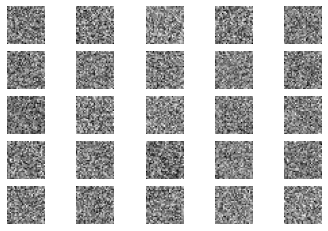

1 [D loss: 0.326030, acc.: 91.99%] [G loss: 0.650031]
2 [D loss: 0.318951, acc.: 90.33%] [G loss: 0.662376]
3 [D loss: 0.329913, acc.: 83.01%] [G loss: 0.697739]
4 [D loss: 0.323175, acc.: 85.45%] [G loss: 0.762797]
5 [D loss: 0.300760, acc.: 91.11%] [G loss: 0.869100]
6 [D loss: 0.270855, acc.: 94.04%] [G loss: 1.004225]
7 [D loss: 0.235486, acc.: 96.97%] [G loss: 1.143670]
8 [D loss: 0.210979, acc.: 98.63%] [G loss: 1.296267]
9 [D loss: 0.175664, acc.: 99.22%] [G loss: 1.461429]
10 [D loss: 0.151933, acc.: 99.61%] [G loss: 1.645836]
11 [D loss: 0.134091, acc.: 99.61%] [G loss: 1.809270]
12 [D loss: 0.118760, acc.: 99.90%] [G loss: 1.976532]
13 [D loss: 0.105006, acc.: 100.00%] [G loss: 2.137161]
14 [D loss: 0.087102, acc.: 100.00%] [G loss: 2.284352]
15 [D loss: 0.078077, acc.: 100.00%] [G loss: 2.408898]
16 [D loss: 0.069676, acc.: 100.00%] [G loss: 2.529748]
17 [D loss: 0.060400, acc.: 100.00%] [G loss: 2.656041]
18 [D loss: 0.055950, acc.: 100.00%] [G loss: 2.749583]
19 [D loss: 0

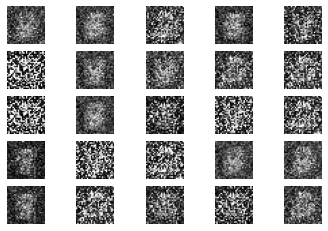

201 [D loss: 0.257875, acc.: 87.60%] [G loss: 2.700397]
202 [D loss: 0.621210, acc.: 66.70%] [G loss: 1.810978]
203 [D loss: 0.244491, acc.: 89.06%] [G loss: 2.833599]
204 [D loss: 0.460207, acc.: 75.00%] [G loss: 2.085878]
205 [D loss: 0.275016, acc.: 87.79%] [G loss: 2.874711]
206 [D loss: 0.595074, acc.: 68.95%] [G loss: 1.919263]
207 [D loss: 0.267107, acc.: 90.33%] [G loss: 2.817912]
208 [D loss: 0.676339, acc.: 65.33%] [G loss: 1.532890]
209 [D loss: 0.264751, acc.: 86.33%] [G loss: 2.752612]
210 [D loss: 0.501096, acc.: 70.80%] [G loss: 1.960329]
211 [D loss: 0.273150, acc.: 88.77%] [G loss: 2.643005]
212 [D loss: 0.555218, acc.: 68.65%] [G loss: 1.814954]
213 [D loss: 0.276691, acc.: 89.45%] [G loss: 2.799624]
214 [D loss: 0.635269, acc.: 66.02%] [G loss: 1.598062]
215 [D loss: 0.244301, acc.: 90.72%] [G loss: 2.807460]
216 [D loss: 0.511607, acc.: 72.46%] [G loss: 1.836633]
217 [D loss: 0.300012, acc.: 85.16%] [G loss: 2.654912]
218 [D loss: 0.738807, acc.: 59.67%] [G loss: 1.

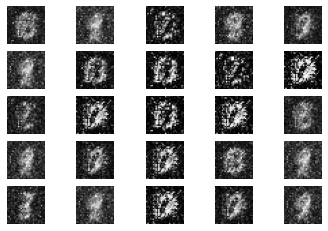

401 [D loss: 0.654521, acc.: 47.17%] [G loss: 0.726428]
402 [D loss: 0.652754, acc.: 47.56%] [G loss: 0.726356]
403 [D loss: 0.662078, acc.: 46.48%] [G loss: 0.727067]
404 [D loss: 0.655667, acc.: 46.97%] [G loss: 0.728822]
405 [D loss: 0.654634, acc.: 48.44%] [G loss: 0.730418]
406 [D loss: 0.654697, acc.: 46.68%] [G loss: 0.733979]
407 [D loss: 0.651982, acc.: 46.97%] [G loss: 0.734898]
408 [D loss: 0.662083, acc.: 47.27%] [G loss: 0.738132]
409 [D loss: 0.662234, acc.: 46.19%] [G loss: 0.732409]
410 [D loss: 0.656903, acc.: 48.14%] [G loss: 0.730197]
411 [D loss: 0.661062, acc.: 46.97%] [G loss: 0.725059]
412 [D loss: 0.660459, acc.: 46.09%] [G loss: 0.721458]
413 [D loss: 0.661598, acc.: 48.14%] [G loss: 0.721858]
414 [D loss: 0.662681, acc.: 46.00%] [G loss: 0.719981]
415 [D loss: 0.651547, acc.: 48.44%] [G loss: 0.720353]
416 [D loss: 0.652250, acc.: 47.46%] [G loss: 0.720779]
417 [D loss: 0.657063, acc.: 48.14%] [G loss: 0.719810]
418 [D loss: 0.651655, acc.: 46.97%] [G loss: 0.

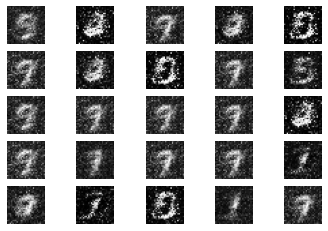

601 [D loss: 0.636677, acc.: 65.33%] [G loss: 0.827890]
602 [D loss: 0.650758, acc.: 63.77%] [G loss: 0.817230]
603 [D loss: 0.638752, acc.: 64.06%] [G loss: 0.831387]
604 [D loss: 0.638106, acc.: 66.70%] [G loss: 0.825804]
605 [D loss: 0.634498, acc.: 68.55%] [G loss: 0.817074]
606 [D loss: 0.635686, acc.: 67.97%] [G loss: 0.816149]
607 [D loss: 0.638032, acc.: 65.53%] [G loss: 0.833643]
608 [D loss: 0.640587, acc.: 64.45%] [G loss: 0.837486]
609 [D loss: 0.626744, acc.: 67.97%] [G loss: 0.840009]
610 [D loss: 0.632656, acc.: 66.21%] [G loss: 0.830535]
611 [D loss: 0.614190, acc.: 69.82%] [G loss: 0.832768]
612 [D loss: 0.625218, acc.: 68.65%] [G loss: 0.832797]
613 [D loss: 0.629785, acc.: 66.41%] [G loss: 0.826745]
614 [D loss: 0.615891, acc.: 69.43%] [G loss: 0.833810]
615 [D loss: 0.625754, acc.: 68.16%] [G loss: 0.825157]
616 [D loss: 0.617996, acc.: 71.19%] [G loss: 0.823427]
617 [D loss: 0.625418, acc.: 68.95%] [G loss: 0.822352]
618 [D loss: 0.621041, acc.: 70.21%] [G loss: 0.

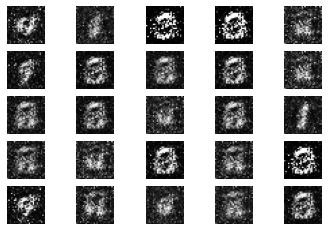

801 [D loss: 0.578344, acc.: 70.70%] [G loss: 0.963829]
802 [D loss: 0.594265, acc.: 66.89%] [G loss: 0.959678]
803 [D loss: 0.585778, acc.: 69.43%] [G loss: 0.967318]
804 [D loss: 0.573099, acc.: 70.21%] [G loss: 0.986082]
805 [D loss: 0.578997, acc.: 69.63%] [G loss: 0.980008]
806 [D loss: 0.580378, acc.: 69.63%] [G loss: 0.964382]
807 [D loss: 0.586071, acc.: 68.16%] [G loss: 0.966574]
808 [D loss: 0.592824, acc.: 68.36%] [G loss: 0.978848]
809 [D loss: 0.585529, acc.: 69.53%] [G loss: 0.984908]
810 [D loss: 0.569954, acc.: 72.27%] [G loss: 1.002232]
811 [D loss: 0.580530, acc.: 69.82%] [G loss: 1.003134]
812 [D loss: 0.572015, acc.: 71.48%] [G loss: 1.026836]
813 [D loss: 0.570148, acc.: 75.39%] [G loss: 1.044874]
814 [D loss: 0.568925, acc.: 75.39%] [G loss: 1.060070]
815 [D loss: 0.556243, acc.: 79.00%] [G loss: 1.073364]
816 [D loss: 0.558432, acc.: 78.42%] [G loss: 1.089377]
817 [D loss: 0.564803, acc.: 77.54%] [G loss: 1.063379]
818 [D loss: 0.558651, acc.: 74.90%] [G loss: 1.

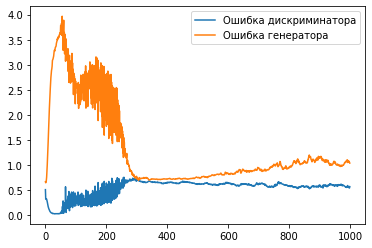

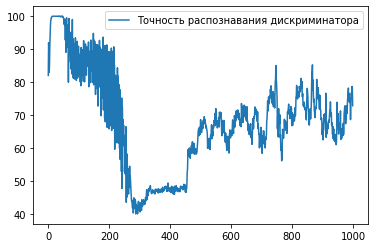

In [ ]:
generator = create_generator()
discriminator = create_discriminator()
train(generator, discriminator, 1000)

# latent_dim = 10

In [ ]:
latent_dim = 10


0 [D loss: 0.861367, acc.: 14.45%] [G loss: 0.597345]


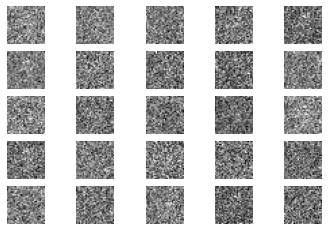

1 [D loss: 0.913631, acc.: 66.70%] [G loss: 4.800111]
2 [D loss: 0.396962, acc.: 76.17%] [G loss: 4.086044]
3 [D loss: 0.312517, acc.: 78.03%] [G loss: 3.824397]
4 [D loss: 9.520311, acc.: 16.70%] [G loss: 2.769759]
5 [D loss: 2.624977, acc.: 70.80%] [G loss: 9.332943]
6 [D loss: 2.830181, acc.: 64.45%] [G loss: 4.956407]
7 [D loss: 1.946917, acc.: 68.46%] [G loss: 4.592298]
8 [D loss: 1.536793, acc.: 66.60%] [G loss: 4.540642]
9 [D loss: 0.660755, acc.: 78.91%] [G loss: 4.725080]
10 [D loss: 0.234520, acc.: 89.55%] [G loss: 4.613554]
11 [D loss: 0.331418, acc.: 83.79%] [G loss: 4.270928]
12 [D loss: 0.350379, acc.: 81.35%] [G loss: 4.798129]
13 [D loss: 4.335807, acc.: 6.54%] [G loss: 1.703154]
14 [D loss: 2.662273, acc.: 53.61%] [G loss: 1.779132]
15 [D loss: 0.927503, acc.: 67.09%] [G loss: 3.264821]
16 [D loss: 0.276115, acc.: 85.74%] [G loss: 3.773807]
17 [D loss: 0.246400, acc.: 87.89%] [G loss: 3.632736]
18 [D loss: 0.272902, acc.: 86.91%] [G loss: 3.364688]
19 [D loss: 0.237347

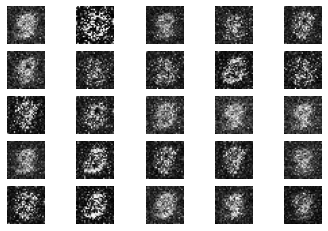

201 [D loss: 0.809400, acc.: 41.99%] [G loss: 0.740900]
202 [D loss: 0.805252, acc.: 42.19%] [G loss: 0.734086]
203 [D loss: 0.803875, acc.: 41.70%] [G loss: 0.730196]
204 [D loss: 0.809506, acc.: 40.14%] [G loss: 0.731854]
205 [D loss: 0.809878, acc.: 41.11%] [G loss: 0.730863]
206 [D loss: 0.803768, acc.: 41.41%] [G loss: 0.730138]
207 [D loss: 0.800828, acc.: 43.07%] [G loss: 0.736392]
208 [D loss: 0.800179, acc.: 42.58%] [G loss: 0.733798]
209 [D loss: 0.800454, acc.: 41.50%] [G loss: 0.731579]
210 [D loss: 0.801289, acc.: 42.58%] [G loss: 0.727934]
211 [D loss: 0.791406, acc.: 42.87%] [G loss: 0.724306]
212 [D loss: 0.797193, acc.: 43.55%] [G loss: 0.728074]
213 [D loss: 0.790889, acc.: 43.26%] [G loss: 0.728992]
214 [D loss: 0.798026, acc.: 42.97%] [G loss: 0.732481]
215 [D loss: 0.795959, acc.: 42.19%] [G loss: 0.735130]
216 [D loss: 0.797230, acc.: 42.48%] [G loss: 0.729361]
217 [D loss: 0.794424, acc.: 44.82%] [G loss: 0.731442]
218 [D loss: 0.797051, acc.: 42.97%] [G loss: 0.

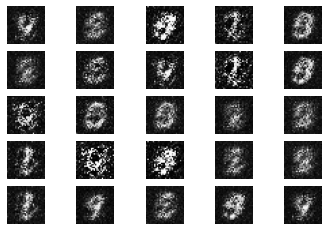

401 [D loss: 0.745823, acc.: 37.89%] [G loss: 0.751142]
402 [D loss: 0.742304, acc.: 37.50%] [G loss: 0.747498]
403 [D loss: 0.741885, acc.: 37.79%] [G loss: 0.746175]
404 [D loss: 0.743099, acc.: 37.70%] [G loss: 0.742335]
405 [D loss: 0.746492, acc.: 37.11%] [G loss: 0.743407]
406 [D loss: 0.752330, acc.: 35.55%] [G loss: 0.741307]
407 [D loss: 0.753795, acc.: 36.04%] [G loss: 0.740478]
408 [D loss: 0.751521, acc.: 36.82%] [G loss: 0.740596]
409 [D loss: 0.752726, acc.: 35.84%] [G loss: 0.741197]
410 [D loss: 0.747611, acc.: 36.52%] [G loss: 0.743157]
411 [D loss: 0.752016, acc.: 35.16%] [G loss: 0.744581]
412 [D loss: 0.755458, acc.: 31.05%] [G loss: 0.742507]
413 [D loss: 0.756257, acc.: 34.08%] [G loss: 0.738771]
414 [D loss: 0.754388, acc.: 34.47%] [G loss: 0.736215]
415 [D loss: 0.749191, acc.: 36.33%] [G loss: 0.739953]
416 [D loss: 0.759537, acc.: 30.76%] [G loss: 0.739888]
417 [D loss: 0.758038, acc.: 31.05%] [G loss: 0.738524]
418 [D loss: 0.755462, acc.: 34.38%] [G loss: 0.

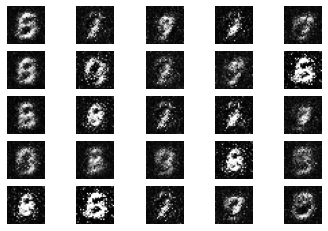

601 [D loss: 0.735146, acc.: 35.74%] [G loss: 0.733852]
602 [D loss: 0.736503, acc.: 35.16%] [G loss: 0.733804]
603 [D loss: 0.740768, acc.: 33.79%] [G loss: 0.731141]
604 [D loss: 0.738980, acc.: 34.57%] [G loss: 0.730611]
605 [D loss: 0.739432, acc.: 33.79%] [G loss: 0.732824]
606 [D loss: 0.736027, acc.: 34.38%] [G loss: 0.733547]
607 [D loss: 0.735656, acc.: 36.43%] [G loss: 0.732417]
608 [D loss: 0.737185, acc.: 34.38%] [G loss: 0.736406]
609 [D loss: 0.736536, acc.: 35.64%] [G loss: 0.738086]
610 [D loss: 0.738556, acc.: 33.98%] [G loss: 0.734820]
611 [D loss: 0.735595, acc.: 35.25%] [G loss: 0.735775]
612 [D loss: 0.732477, acc.: 35.45%] [G loss: 0.736810]
613 [D loss: 0.731513, acc.: 37.01%] [G loss: 0.737439]
614 [D loss: 0.729923, acc.: 36.23%] [G loss: 0.739847]
615 [D loss: 0.730304, acc.: 36.04%] [G loss: 0.740096]
616 [D loss: 0.729645, acc.: 36.72%] [G loss: 0.743147]
617 [D loss: 0.726453, acc.: 37.60%] [G loss: 0.744193]
618 [D loss: 0.727169, acc.: 36.33%] [G loss: 0.

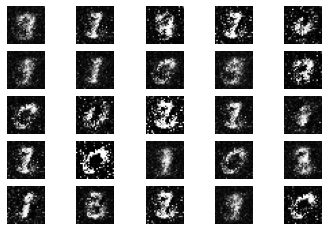

801 [D loss: 0.706477, acc.: 41.99%] [G loss: 0.755838]
802 [D loss: 0.709525, acc.: 43.55%] [G loss: 0.754018]
803 [D loss: 0.705598, acc.: 46.00%] [G loss: 0.754092]
804 [D loss: 0.711413, acc.: 43.26%] [G loss: 0.751561]
805 [D loss: 0.710028, acc.: 42.38%] [G loss: 0.748044]
806 [D loss: 0.710420, acc.: 42.29%] [G loss: 0.745764]
807 [D loss: 0.708819, acc.: 41.80%] [G loss: 0.748928]
808 [D loss: 0.705014, acc.: 41.89%] [G loss: 0.745753]
809 [D loss: 0.703475, acc.: 42.38%] [G loss: 0.748479]
810 [D loss: 0.701977, acc.: 40.72%] [G loss: 0.753383]
811 [D loss: 0.703668, acc.: 41.99%] [G loss: 0.750406]
812 [D loss: 0.702196, acc.: 41.70%] [G loss: 0.751201]
813 [D loss: 0.705721, acc.: 39.06%] [G loss: 0.751033]
814 [D loss: 0.703793, acc.: 41.99%] [G loss: 0.750319]
815 [D loss: 0.708703, acc.: 41.70%] [G loss: 0.750660]
816 [D loss: 0.703995, acc.: 41.89%] [G loss: 0.752814]
817 [D loss: 0.705498, acc.: 41.89%] [G loss: 0.753020]
818 [D loss: 0.707457, acc.: 42.68%] [G loss: 0.

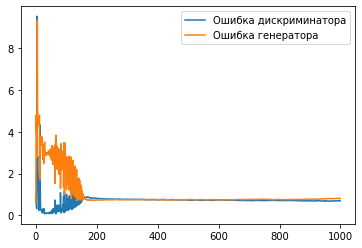

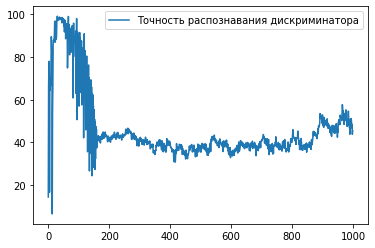

In [ ]:
generator = create_generator()
discriminator = create_discriminator()
train(generator, discriminator, 1000)

# latent_dim = 1000

In [ ]:
latent_dim = 1000

0 [D loss: 0.830403, acc.: 44.73%] [G loss: 0.483526]


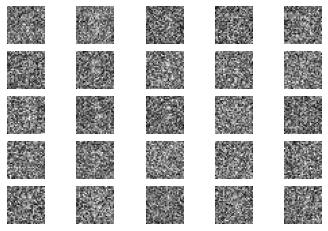

1 [D loss: 3.637197, acc.: 50.20%] [G loss: 0.950373]
2 [D loss: 0.181381, acc.: 92.38%] [G loss: 1.664118]
3 [D loss: 10.593698, acc.: 1.66%] [G loss: 1.410439]
4 [D loss: 0.612946, acc.: 79.00%] [G loss: 2.428553]
5 [D loss: 0.562622, acc.: 78.42%] [G loss: 1.832508]
6 [D loss: 0.909937, acc.: 68.65%] [G loss: 1.929282]
7 [D loss: 0.912045, acc.: 69.92%] [G loss: 2.372983]
8 [D loss: 0.403441, acc.: 77.93%] [G loss: 2.389733]
9 [D loss: 0.223642, acc.: 88.87%] [G loss: 2.695028]
10 [D loss: 0.148055, acc.: 94.04%] [G loss: 2.714953]
11 [D loss: 0.105027, acc.: 97.85%] [G loss: 2.633303]
12 [D loss: 0.105721, acc.: 97.75%] [G loss: 2.605432]
13 [D loss: 0.084656, acc.: 99.02%] [G loss: 2.617106]
14 [D loss: 0.095447, acc.: 98.34%] [G loss: 2.608755]
15 [D loss: 0.086102, acc.: 98.73%] [G loss: 2.653167]
16 [D loss: 0.075382, acc.: 99.32%] [G loss: 2.704149]
17 [D loss: 0.114651, acc.: 97.85%] [G loss: 2.323166]
18 [D loss: 0.109266, acc.: 97.36%] [G loss: 2.418239]
19 [D loss: 0.08963

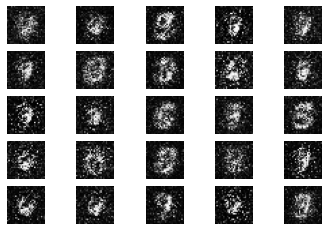

201 [D loss: 0.753278, acc.: 39.26%] [G loss: 0.693131]
202 [D loss: 0.749837, acc.: 41.70%] [G loss: 0.694589]
203 [D loss: 0.754480, acc.: 37.30%] [G loss: 0.692882]
204 [D loss: 0.756875, acc.: 37.99%] [G loss: 0.693918]
205 [D loss: 0.753554, acc.: 38.18%] [G loss: 0.693885]
206 [D loss: 0.752160, acc.: 37.40%] [G loss: 0.691678]
207 [D loss: 0.755325, acc.: 37.79%] [G loss: 0.688833]
208 [D loss: 0.753254, acc.: 37.89%] [G loss: 0.688175]
209 [D loss: 0.752863, acc.: 37.89%] [G loss: 0.686383]
210 [D loss: 0.752141, acc.: 39.94%] [G loss: 0.688098]
211 [D loss: 0.751801, acc.: 37.50%] [G loss: 0.686331]
212 [D loss: 0.751488, acc.: 37.60%] [G loss: 0.683279]
213 [D loss: 0.749618, acc.: 40.23%] [G loss: 0.682720]
214 [D loss: 0.750765, acc.: 38.09%] [G loss: 0.684676]
215 [D loss: 0.747039, acc.: 38.87%] [G loss: 0.685642]
216 [D loss: 0.746729, acc.: 39.36%] [G loss: 0.685148]
217 [D loss: 0.747954, acc.: 37.11%] [G loss: 0.684834]
218 [D loss: 0.746987, acc.: 37.60%] [G loss: 0.

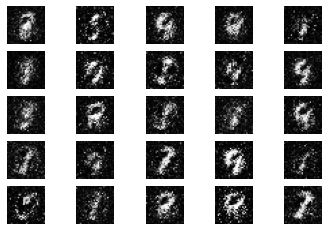

401 [D loss: 0.717107, acc.: 39.06%] [G loss: 0.693261]
402 [D loss: 0.717426, acc.: 38.57%] [G loss: 0.693461]
403 [D loss: 0.718729, acc.: 37.99%] [G loss: 0.695371]
404 [D loss: 0.715287, acc.: 38.87%] [G loss: 0.697060]
405 [D loss: 0.715187, acc.: 39.26%] [G loss: 0.698741]
406 [D loss: 0.718408, acc.: 37.21%] [G loss: 0.697696]
407 [D loss: 0.719498, acc.: 35.94%] [G loss: 0.697149]
408 [D loss: 0.715803, acc.: 40.04%] [G loss: 0.696884]
409 [D loss: 0.714537, acc.: 39.26%] [G loss: 0.698307]
410 [D loss: 0.714822, acc.: 39.36%] [G loss: 0.696854]
411 [D loss: 0.714050, acc.: 40.82%] [G loss: 0.697152]
412 [D loss: 0.712857, acc.: 40.53%] [G loss: 0.698506]
413 [D loss: 0.711201, acc.: 39.75%] [G loss: 0.698152]
414 [D loss: 0.715402, acc.: 39.55%] [G loss: 0.695855]
415 [D loss: 0.711380, acc.: 41.41%] [G loss: 0.697323]
416 [D loss: 0.712020, acc.: 40.43%] [G loss: 0.697763]
417 [D loss: 0.711115, acc.: 41.31%] [G loss: 0.699103]
418 [D loss: 0.709863, acc.: 40.62%] [G loss: 0.

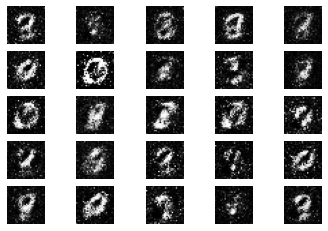

601 [D loss: 0.698521, acc.: 41.60%] [G loss: 0.711513]
602 [D loss: 0.697234, acc.: 43.75%] [G loss: 0.712289]
603 [D loss: 0.700519, acc.: 42.48%] [G loss: 0.711400]
604 [D loss: 0.693950, acc.: 43.26%] [G loss: 0.713980]
605 [D loss: 0.696842, acc.: 43.16%] [G loss: 0.711875]
606 [D loss: 0.698261, acc.: 43.75%] [G loss: 0.712730]
607 [D loss: 0.698701, acc.: 42.77%] [G loss: 0.711769]
608 [D loss: 0.699484, acc.: 40.82%] [G loss: 0.711520]
609 [D loss: 0.694683, acc.: 43.07%] [G loss: 0.713741]
610 [D loss: 0.697279, acc.: 41.41%] [G loss: 0.713969]
611 [D loss: 0.697752, acc.: 38.87%] [G loss: 0.713405]
612 [D loss: 0.696424, acc.: 40.23%] [G loss: 0.712537]
613 [D loss: 0.692889, acc.: 41.50%] [G loss: 0.712946]
614 [D loss: 0.697766, acc.: 40.14%] [G loss: 0.709143]
615 [D loss: 0.696792, acc.: 40.14%] [G loss: 0.709174]
616 [D loss: 0.700745, acc.: 38.77%] [G loss: 0.706942]
617 [D loss: 0.698437, acc.: 40.14%] [G loss: 0.708721]
618 [D loss: 0.701428, acc.: 38.09%] [G loss: 0.

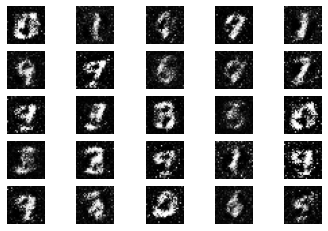

801 [D loss: 0.682691, acc.: 45.02%] [G loss: 0.719511]
802 [D loss: 0.681221, acc.: 47.66%] [G loss: 0.721402]
803 [D loss: 0.681428, acc.: 46.58%] [G loss: 0.718432]
804 [D loss: 0.686699, acc.: 46.68%] [G loss: 0.714823]
805 [D loss: 0.680308, acc.: 47.46%] [G loss: 0.720851]
806 [D loss: 0.683621, acc.: 47.27%] [G loss: 0.721662]
807 [D loss: 0.679479, acc.: 49.71%] [G loss: 0.720368]
808 [D loss: 0.682316, acc.: 47.75%] [G loss: 0.723238]
809 [D loss: 0.685929, acc.: 46.58%] [G loss: 0.723462]
810 [D loss: 0.681055, acc.: 49.51%] [G loss: 0.724143]
811 [D loss: 0.679876, acc.: 50.49%] [G loss: 0.722897]
812 [D loss: 0.681385, acc.: 50.88%] [G loss: 0.725533]
813 [D loss: 0.681987, acc.: 48.44%] [G loss: 0.720033]
814 [D loss: 0.681167, acc.: 51.46%] [G loss: 0.727604]
815 [D loss: 0.679350, acc.: 52.64%] [G loss: 0.724019]
816 [D loss: 0.677950, acc.: 54.20%] [G loss: 0.726318]
817 [D loss: 0.683089, acc.: 51.56%] [G loss: 0.724716]
818 [D loss: 0.680573, acc.: 52.54%] [G loss: 0.

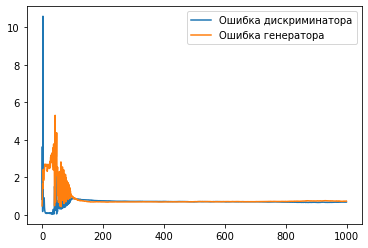

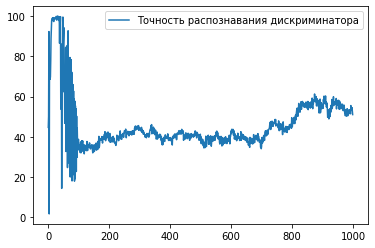

In [ ]:
generator = create_generator()
discriminator = create_discriminator()
train(generator, discriminator, 1000)

промежуточный вывод: сравнивая результаты обучения, при разных размерах скрытого пространства, из графиков видно, что наилучшим образом модель обучалась при скрытом пространстве 1000. При latent_dim = 100 наблюдалось переобучение. При latent_dim =10 движухи особо не наблюдалось.

# Свёрточный генератор

In [ ]:
def create_conv_generator():
  generator = Sequential()
  generator.add(Dense(256, input_dim=latent_dim))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(Dense(512)) 
  generator.add(Dense(7*7)) # вот тут была рельная проблема
  generator.add(Reshape((7, 7, 1)))
  generator.add(Conv2D(64, 2, padding='same'))
  generator.add(Flatten())
  generator.add(Dense(np.prod(img_shape), activation='tanh'))
  
  generator.add(Reshape((28, 28, 1)))
  noise = Input(shape=(latent_dim, )) # данные входа с размерностью latent_dim
  img = generator(noise) #  созданное генератором из noise

  generator = Model(noise, img) # модель вход-выход

  return generator

In [ ]:
des = create_conv_generator()
des.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_1 (Sequential)   (None, 28, 28, 1)         2642305   
                                                                 
Total params: 2,642,305
Trainable params: 2,642,305
Non-trainable params: 0
_________________________________________________________________


0 [D loss: 0.699684, acc.: 51.56%] [G loss: 0.706894]


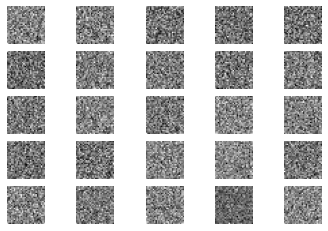

1 [D loss: 0.479441, acc.: 50.00%] [G loss: 0.551087]
2 [D loss: 0.645989, acc.: 50.00%] [G loss: 0.379957]
3 [D loss: 0.975881, acc.: 50.00%] [G loss: 0.225179]
4 [D loss: 1.371607, acc.: 50.00%] [G loss: 0.137085]
5 [D loss: 1.512913, acc.: 50.00%] [G loss: 0.139237]
6 [D loss: 1.395563, acc.: 50.00%] [G loss: 0.229873]
7 [D loss: 1.147479, acc.: 50.00%] [G loss: 0.424643]
8 [D loss: 0.841655, acc.: 50.00%] [G loss: 0.782650]
9 [D loss: 0.598763, acc.: 50.00%] [G loss: 1.108330]
10 [D loss: 0.505355, acc.: 50.00%] [G loss: 1.149362]
11 [D loss: 0.481743, acc.: 50.10%] [G loss: 1.088856]
12 [D loss: 0.489558, acc.: 50.00%] [G loss: 1.032635]
13 [D loss: 0.525553, acc.: 50.00%] [G loss: 0.986977]
14 [D loss: 0.583992, acc.: 50.00%] [G loss: 0.905029]
15 [D loss: 0.708634, acc.: 50.00%] [G loss: 0.773291]
16 [D loss: 0.891244, acc.: 50.00%] [G loss: 0.642471]
17 [D loss: 0.988842, acc.: 50.00%] [G loss: 0.639243]
18 [D loss: 0.866999, acc.: 50.00%] [G loss: 0.880300]
19 [D loss: 0.65218

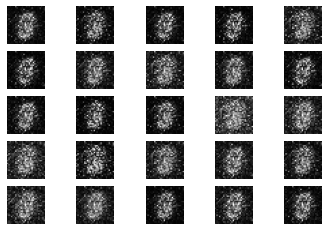

201 [D loss: 0.755522, acc.: 26.95%] [G loss: 0.836835]
202 [D loss: 0.756216, acc.: 26.86%] [G loss: 0.817450]
203 [D loss: 0.751711, acc.: 30.57%] [G loss: 0.785769]
204 [D loss: 0.727318, acc.: 38.77%] [G loss: 0.789325]
205 [D loss: 0.697068, acc.: 42.29%] [G loss: 0.804425]
206 [D loss: 0.669826, acc.: 46.68%] [G loss: 0.813769]
207 [D loss: 0.647180, acc.: 48.24%] [G loss: 0.823730]
208 [D loss: 0.621249, acc.: 53.22%] [G loss: 0.850545]
209 [D loss: 0.600822, acc.: 54.69%] [G loss: 0.860658]
210 [D loss: 0.603296, acc.: 53.22%] [G loss: 0.851399]
211 [D loss: 0.618206, acc.: 50.78%] [G loss: 0.819373]
212 [D loss: 0.634556, acc.: 50.20%] [G loss: 0.791829]
213 [D loss: 0.652827, acc.: 49.61%] [G loss: 0.767227]
214 [D loss: 0.658922, acc.: 49.90%] [G loss: 0.746424]
215 [D loss: 0.672049, acc.: 49.22%] [G loss: 0.727152]
216 [D loss: 0.669198, acc.: 49.51%] [G loss: 0.745673]
217 [D loss: 0.651650, acc.: 49.41%] [G loss: 0.778556]
218 [D loss: 0.646220, acc.: 49.51%] [G loss: 0.

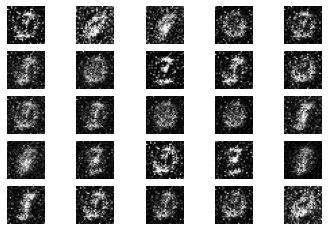

401 [D loss: 0.660951, acc.: 54.39%] [G loss: 0.919590]
402 [D loss: 0.679786, acc.: 48.14%] [G loss: 0.911236]
403 [D loss: 0.694058, acc.: 42.68%] [G loss: 0.873335]
404 [D loss: 0.708727, acc.: 37.11%] [G loss: 0.839593]
405 [D loss: 0.724272, acc.: 34.96%] [G loss: 0.820487]
406 [D loss: 0.676237, acc.: 44.14%] [G loss: 0.846157]
407 [D loss: 0.662748, acc.: 51.56%] [G loss: 0.868150]
408 [D loss: 0.647762, acc.: 59.67%] [G loss: 0.876924]
409 [D loss: 0.648509, acc.: 59.18%] [G loss: 0.865637]
410 [D loss: 0.642852, acc.: 57.91%] [G loss: 0.865388]
411 [D loss: 0.651963, acc.: 54.88%] [G loss: 0.870765]
412 [D loss: 0.649963, acc.: 54.00%] [G loss: 0.874369]
413 [D loss: 0.657088, acc.: 53.91%] [G loss: 0.875278]
414 [D loss: 0.674071, acc.: 50.10%] [G loss: 0.854060]
415 [D loss: 0.684520, acc.: 45.70%] [G loss: 0.830080]
416 [D loss: 0.681780, acc.: 45.90%] [G loss: 0.826477]
417 [D loss: 0.676993, acc.: 43.75%] [G loss: 0.839982]
418 [D loss: 0.669994, acc.: 46.97%] [G loss: 0.

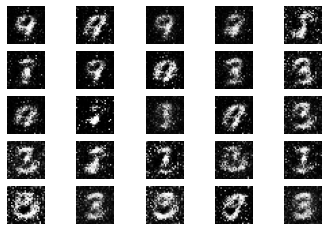

601 [D loss: 0.688636, acc.: 46.19%] [G loss: 0.813229]
602 [D loss: 0.686002, acc.: 50.98%] [G loss: 0.811759]
603 [D loss: 0.682725, acc.: 52.54%] [G loss: 0.827162]
604 [D loss: 0.681067, acc.: 51.95%] [G loss: 0.833875]
605 [D loss: 0.684314, acc.: 53.03%] [G loss: 0.837248]
606 [D loss: 0.684861, acc.: 54.00%] [G loss: 0.836421]
607 [D loss: 0.689939, acc.: 49.22%] [G loss: 0.823987]
608 [D loss: 0.692401, acc.: 46.97%] [G loss: 0.795411]
609 [D loss: 0.700463, acc.: 43.07%] [G loss: 0.778207]
610 [D loss: 0.689021, acc.: 46.68%] [G loss: 0.778078]
611 [D loss: 0.684914, acc.: 45.41%] [G loss: 0.785397]
612 [D loss: 0.683461, acc.: 46.68%] [G loss: 0.789598]
613 [D loss: 0.676209, acc.: 49.02%] [G loss: 0.800010]
614 [D loss: 0.679798, acc.: 48.24%] [G loss: 0.797998]
615 [D loss: 0.681244, acc.: 47.66%] [G loss: 0.791001]
616 [D loss: 0.667657, acc.: 51.17%] [G loss: 0.793685]
617 [D loss: 0.672994, acc.: 48.54%] [G loss: 0.789755]
618 [D loss: 0.667529, acc.: 50.00%] [G loss: 0.

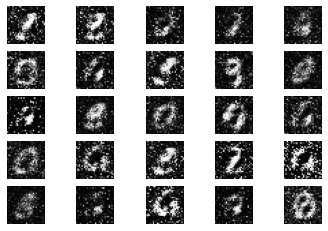

801 [D loss: 0.595644, acc.: 75.98%] [G loss: 0.904063]
802 [D loss: 0.589437, acc.: 75.49%] [G loss: 0.910058]
803 [D loss: 0.595674, acc.: 71.78%] [G loss: 0.897658]
804 [D loss: 0.592404, acc.: 70.80%] [G loss: 0.898122]
805 [D loss: 0.602545, acc.: 67.77%] [G loss: 0.904791]
806 [D loss: 0.613451, acc.: 66.50%] [G loss: 0.903887]
807 [D loss: 0.626733, acc.: 63.96%] [G loss: 0.898025]
808 [D loss: 0.646010, acc.: 55.76%] [G loss: 0.877807]
809 [D loss: 0.650136, acc.: 56.35%] [G loss: 0.875882]
810 [D loss: 0.641007, acc.: 58.30%] [G loss: 0.881358]
811 [D loss: 0.645771, acc.: 59.96%] [G loss: 0.891899]
812 [D loss: 0.640369, acc.: 64.45%] [G loss: 0.894170]
813 [D loss: 0.620426, acc.: 69.53%] [G loss: 0.902122]
814 [D loss: 0.613617, acc.: 70.70%] [G loss: 0.895770]
815 [D loss: 0.603482, acc.: 70.51%] [G loss: 0.906415]
816 [D loss: 0.601220, acc.: 71.39%] [G loss: 0.909732]
817 [D loss: 0.595381, acc.: 72.17%] [G loss: 0.910994]
818 [D loss: 0.592988, acc.: 74.80%] [G loss: 0.

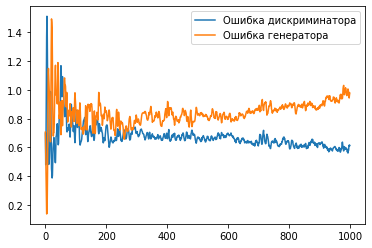

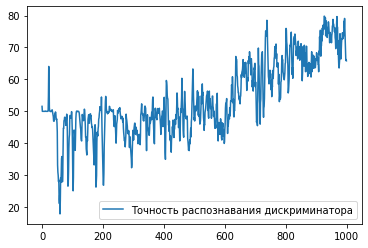

In [ ]:
generator = create_conv_generator()
discriminator = create_discriminator()
train(generator, discriminator, 1000,)

Промежуточный вывод: со свёрточным генератором картина лучше, чем с полносвязным, но генератор стремится к переобучению. это связано с архитектурой генератора. Если его подработать, можно получить не плохие результаты. 

# Генератор Батч=256, дискриминатор=128

In [ ]:
def train_1(generator, discriminator, epochs= 10000, batch_size=batch_size):
  valid = np.ones((128, 1)) # единички массив
  fake = np.zeros((128, 1)) # нули массив

  z = Input(shape=(latent_dim, ), batch_size=256)
  img = generator(z) # генерируется из z от латентного входа
  validity = discriminator(img) # короче, целая цепочка от входа данная переменная. Это что даёт дискриминатор
  combined = Model(z, validity) # вход-выход
  combined.compile(loss='binary_crossentropy', optimizer=optimizer) 

  sample_interval =200 # интервал через которые будет отрисовыватся изображение

  d_loss_list =[] # пустой массив дискриминатора
  g_loss_list = [] # пустой массив генератора
  d_acc_list = [] # массив точности модели

  for epoch in range(epochs):  # обучение дискриминатора
    idx = np.random.randint(0, X_train.shape[0], 128)# берём кусок размера батч, в диапазоне X_train
    imgs = X_train[idx] # случайное значение, полученное в idx записываем в переменную
    
    noise = np.random.normal(0, 1, (128, latent_dim)) # массив из батча и латента.. нормального распределения
    gen_imgs = generator.predict(noise) # генератором из ф-ции предиктим шум из пространства выше 

    d_loss_real = discriminator.train_on_batch(imgs, valid) # ошибка дискриминатора на реальной картинке
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake) # тоже самое только на сгенерированной картинке
    d_loss = 0.5*np.add(d_loss_real, d_loss_fake)

    # генератор
    g_loss = combined.train_on_batch(noise, valid) # шум и единички

    # скопирую:
    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

    # тут не очень понятно
    d_loss_list.append(d_loss[0]) #массив ошибок дискриминатора первое значение
    g_loss_list.append(g_loss) # массив ошибок генератора
    d_acc_list.append(100*d_loss[1])

    if ((epoch % sample_interval==0)|(epoch==epoch-1)): # условие на вывод монитора 200 эпох
      sample_images(epoch, generator)
  plt.plot(d_loss_list, label='Ошибка дискриминатора')
  plt.plot(g_loss_list, label='Ошибка генератора')
  plt.legend()
  plt.show()
  plt.plot(d_acc_list, label='Точность распознавания дискриминатора')
  plt.legend()
  plt.show()

0 [D loss: 0.769467, acc.: 37.11%] [G loss: 0.964103]


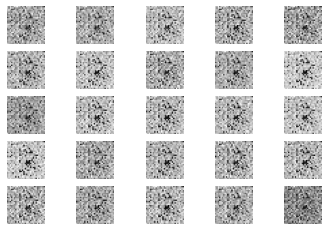

1 [D loss: 0.000041, acc.: 100.00%] [G loss: 16.658924]
2 [D loss: 32.224113, acc.: 50.00%] [G loss: 12.701800]
3 [D loss: 11.229791, acc.: 0.00%] [G loss: 1.401046]
4 [D loss: 1.385091, acc.: 50.00%] [G loss: 6.905554]
5 [D loss: 6.506864, acc.: 0.00%] [G loss: 5.498277]
6 [D loss: 0.458115, acc.: 62.89%] [G loss: 8.334426]
7 [D loss: 0.090429, acc.: 100.00%] [G loss: 6.656277]
8 [D loss: 1.559080, acc.: 50.00%] [G loss: 10.318237]
9 [D loss: 1.449144, acc.: 23.05%] [G loss: 7.346765]
10 [D loss: 5.625598, acc.: 50.00%] [G loss: 9.329775]
11 [D loss: 0.101761, acc.: 99.22%] [G loss: 8.015079]
12 [D loss: 1.275678, acc.: 50.00%] [G loss: 8.952874]
13 [D loss: 0.712842, acc.: 54.30%] [G loss: 6.561978]
14 [D loss: 0.787410, acc.: 41.80%] [G loss: 4.870615]
15 [D loss: 0.277071, acc.: 97.27%] [G loss: 3.591558]
16 [D loss: 0.138395, acc.: 100.00%] [G loss: 3.585681]
17 [D loss: 0.149996, acc.: 99.22%] [G loss: 3.923009]
18 [D loss: 0.265446, acc.: 99.22%] [G loss: 4.361516]
19 [D loss: 0

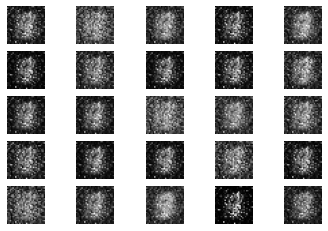

201 [D loss: 0.873880, acc.: 33.59%] [G loss: 0.860779]
202 [D loss: 0.934474, acc.: 28.52%] [G loss: 0.830706]
203 [D loss: 0.825893, acc.: 37.50%] [G loss: 0.907064]
204 [D loss: 0.866500, acc.: 26.56%] [G loss: 0.876036]
205 [D loss: 0.870697, acc.: 30.08%] [G loss: 0.874751]
206 [D loss: 0.840222, acc.: 33.59%] [G loss: 0.949140]
207 [D loss: 0.877601, acc.: 20.31%] [G loss: 0.967274]
208 [D loss: 0.881805, acc.: 13.67%] [G loss: 0.883922]
209 [D loss: 0.843995, acc.: 32.81%] [G loss: 0.932311]
210 [D loss: 0.796686, acc.: 30.47%] [G loss: 0.988082]
211 [D loss: 0.784496, acc.: 28.12%] [G loss: 1.000340]
212 [D loss: 0.805667, acc.: 25.00%] [G loss: 0.942673]
213 [D loss: 0.785649, acc.: 29.30%] [G loss: 0.897128]
214 [D loss: 0.773302, acc.: 33.20%] [G loss: 0.915814]
215 [D loss: 0.752149, acc.: 35.16%] [G loss: 0.975788]
216 [D loss: 0.812073, acc.: 24.22%] [G loss: 0.891820]
217 [D loss: 0.794667, acc.: 30.08%] [G loss: 0.865632]
218 [D loss: 0.813595, acc.: 26.56%] [G loss: 0.

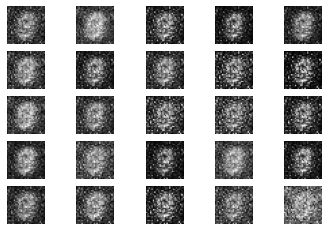

401 [D loss: 0.498549, acc.: 93.36%] [G loss: 0.994277]
402 [D loss: 0.471423, acc.: 96.88%] [G loss: 1.031729]
403 [D loss: 0.498679, acc.: 94.92%] [G loss: 1.016398]
404 [D loss: 0.470654, acc.: 96.48%] [G loss: 1.008238]
405 [D loss: 0.465519, acc.: 95.31%] [G loss: 1.033953]
406 [D loss: 0.445798, acc.: 97.27%] [G loss: 1.068504]
407 [D loss: 0.465996, acc.: 96.88%] [G loss: 1.064126]
408 [D loss: 0.448927, acc.: 99.22%] [G loss: 1.063787]
409 [D loss: 0.437146, acc.: 99.22%] [G loss: 1.090584]
410 [D loss: 0.433234, acc.: 99.61%] [G loss: 1.096619]
411 [D loss: 0.424446, acc.: 98.83%] [G loss: 1.100400]
412 [D loss: 0.432559, acc.: 98.05%] [G loss: 1.097192]
413 [D loss: 0.449437, acc.: 98.83%] [G loss: 1.074034]
414 [D loss: 0.438425, acc.: 97.27%] [G loss: 1.065493]
415 [D loss: 0.429103, acc.: 96.48%] [G loss: 1.074399]
416 [D loss: 0.433443, acc.: 98.05%] [G loss: 1.079245]
417 [D loss: 0.411351, acc.: 100.00%] [G loss: 1.087686]
418 [D loss: 0.429015, acc.: 98.05%] [G loss: 1

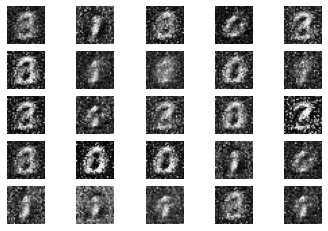

601 [D loss: 0.560091, acc.: 68.75%] [G loss: 1.044411]
602 [D loss: 0.573683, acc.: 64.06%] [G loss: 0.988821]
603 [D loss: 0.564830, acc.: 66.02%] [G loss: 1.014443]
604 [D loss: 0.535505, acc.: 77.34%] [G loss: 1.033474]
605 [D loss: 0.577416, acc.: 66.02%] [G loss: 0.973537]
606 [D loss: 0.558158, acc.: 67.97%] [G loss: 1.002951]
607 [D loss: 0.561789, acc.: 66.41%] [G loss: 1.027128]
608 [D loss: 0.581195, acc.: 64.84%] [G loss: 1.001236]
609 [D loss: 0.590147, acc.: 60.55%] [G loss: 0.994679]
610 [D loss: 0.597341, acc.: 61.33%] [G loss: 0.959711]
611 [D loss: 0.563206, acc.: 64.06%] [G loss: 1.015141]
612 [D loss: 0.562582, acc.: 67.19%] [G loss: 1.050226]
613 [D loss: 0.615667, acc.: 57.81%] [G loss: 0.940248]
614 [D loss: 0.576999, acc.: 64.45%] [G loss: 0.985206]
615 [D loss: 0.571458, acc.: 65.62%] [G loss: 1.037148]
616 [D loss: 0.600171, acc.: 60.16%] [G loss: 1.008891]
617 [D loss: 0.618839, acc.: 60.55%] [G loss: 0.962591]
618 [D loss: 0.559830, acc.: 64.84%] [G loss: 1.

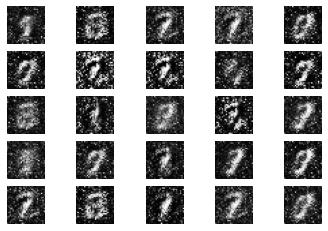

801 [D loss: 0.593440, acc.: 69.92%] [G loss: 1.202207]
802 [D loss: 0.527530, acc.: 78.12%] [G loss: 1.291951]
803 [D loss: 0.523860, acc.: 81.64%] [G loss: 1.326444]
804 [D loss: 0.582933, acc.: 67.97%] [G loss: 1.238342]
805 [D loss: 0.535222, acc.: 78.12%] [G loss: 1.269105]
806 [D loss: 0.601096, acc.: 60.94%] [G loss: 1.217238]
807 [D loss: 0.606130, acc.: 61.33%] [G loss: 1.216291]
808 [D loss: 0.593061, acc.: 70.70%] [G loss: 1.196796]
809 [D loss: 0.579469, acc.: 69.92%] [G loss: 1.204121]
810 [D loss: 0.597579, acc.: 63.28%] [G loss: 1.192897]
811 [D loss: 0.642128, acc.: 60.94%] [G loss: 1.154678]
812 [D loss: 0.591274, acc.: 65.62%] [G loss: 1.165203]
813 [D loss: 0.609612, acc.: 64.06%] [G loss: 1.133510]
814 [D loss: 0.595048, acc.: 62.50%] [G loss: 1.171799]
815 [D loss: 0.580113, acc.: 68.75%] [G loss: 1.188514]
816 [D loss: 0.592625, acc.: 69.14%] [G loss: 1.185376]
817 [D loss: 0.550918, acc.: 73.44%] [G loss: 1.223255]
818 [D loss: 0.535385, acc.: 79.69%] [G loss: 1.

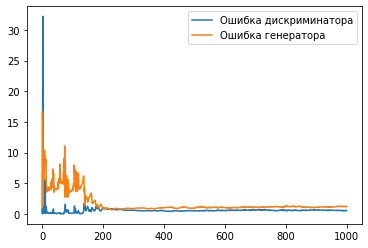

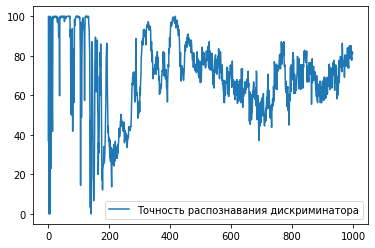

In [ ]:
generator = create_conv_generator()
discriminator = create_discriminator()
train_1(generator, discriminator, 1000,)

промежуточный вывод: в первый раз запускал там была вообще полная чепуха. Это второй раз. К 200-й эпохе ошибки устаканились, и точность начала возрастать. может и дальше будет, задача в этом не стояла. Замена Батча генератора состояла в прибавления параметра batch_size = 256  в переменной 'z'

# ВЫВОД



---
**Общий вывод:** Сделал 2 модели с различными параметрами скрытого слоя и на последней модели с разными Батчами генератора и дискриминатора. Лучше всего показала модель со скрытым слоем 1000. Хотя если смотреть визуально, то различий мало. Одним словом плохо. В литературе вычитал, что это процесс длительного обучения, а у меня всего 1000 эпох. Занятие дало мне чёткое понимание вывода размерностей из полносвязных слоёв в свёрточные.. Это была основная трудность выполнения задания.
